<a href="https://colab.research.google.com/github/03aquamarine/YuJin-s/blob/main/0720Thu_BottleData_%EA%B0%9C%EC%9D%B8%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B802_%EB%B6%88%EB%9F%89%EC%A0%9C%ED%92%88_%EC%9E%90%EB%8F%99%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. data 불러오기
2. labeling
3. 전처리
4. 학습
5. predict

# 1. Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data 일괄 불러오기
import os , glob

good_data = glob.glob('/content/drive/MyDrive/bottle/train/good/*')
anomaly_data = glob.glob('/content/drive/MyDrive/bottle/test/*/*.png')

In [ ]:
good_data
anomaly_data

# 2. Data labeling & preprocessing


In [4]:
import numpy as np
from PIL import Image

# 1. resize
# 2. type( RGB로)
# 3. 픽셀값 0~1 normalize (cf.생성 -1 ~ 1)
# 4. numpy

x = []
y = []
data_folder = [good_data,anomaly_data]

for idx,folder in enumerate(data_folder):
  for file_path in folder:
      # 1. resize
      image = Image.open(file_path)
      image = image.resize((128,128))

      # 2. type to RGB
      image = image.convert("RGB")

      # 3. normalize pixel values (0~1)
      image = np.array(image) / 255

      # 4. store images as a numpy array
      x.append(image)
      y.append(idx)

x = np.array(x)
y = np.array(y)

In [5]:
from sklearn.model_selection import train_test_split

# training sets와 testing sets로 data 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Shuffle the training data
shuffle_indices = np.arange(len(x_train))
np.random.shuffle(shuffle_indices)
x_train = x_train[shuffle_indices]
y_train = y_train[shuffle_indices]


# 3. Model learning

In [6]:
# VGG16 model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.utils import to_categorical

### 에러)`logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)) 해결하기 위해 one-hot encoding
### one-hot encoding : converts categorical labels into a binary matrix
# Convert y_train and y_test to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

# Load the VGG16 model (without the top classification layer)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers in VGG16
for layer in vgg16_base.layers:
    layer.trainable = False

# Create a new model with VGG16 as the base
model = Sequential()
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Change the units to 2 for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15,763,650
Trainable params: 1,048,962
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Train the model and store the history
history = model.fit(x_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print("Test accuracy:", test_acc)


Epoch 1/10
7/7 [==============================] - 14s 731ms/step - loss: 0.8129 - accuracy: 0.6603 - val_loss: 0.5223 - val_accuracy: 0.8333
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.5292 - accuracy: 0.7416 - val_loss: 0.4234 - val_accuracy: 0.8333
Epoch 3/10
7/7 [==============================] - 0s 55ms/step - loss: 0.4860 - accuracy: 0.7847 - val_loss: 0.3961 - val_accuracy: 0.8333
Epoch 4/10
7/7 [==============================] - 0s 49ms/step - loss: 0.4386 - accuracy: 0.8134 - val_loss: 0.3622 - val_accuracy: 0.8333
Epoch 5/10
7/7 [==============================] - 0s 49ms/step - loss: 0.4221 - accuracy: 0.8517 - val_loss: 0.3422 - val_accuracy: 0.8333
Epoch 6/10
7/7 [==============================] - 0s 50ms/step - loss: 0.3907 - accuracy: 0.8612 - val_loss: 0.3220 - val_accuracy: 0.8750
Epoch 7/10
7/7 [==============================] - 0s 49ms/step - loss: 0.3690 - accuracy: 0.8708 - val_loss: 0.3090 - val_accuracy: 0.9167
Epoch 8/10
7/7 [=========

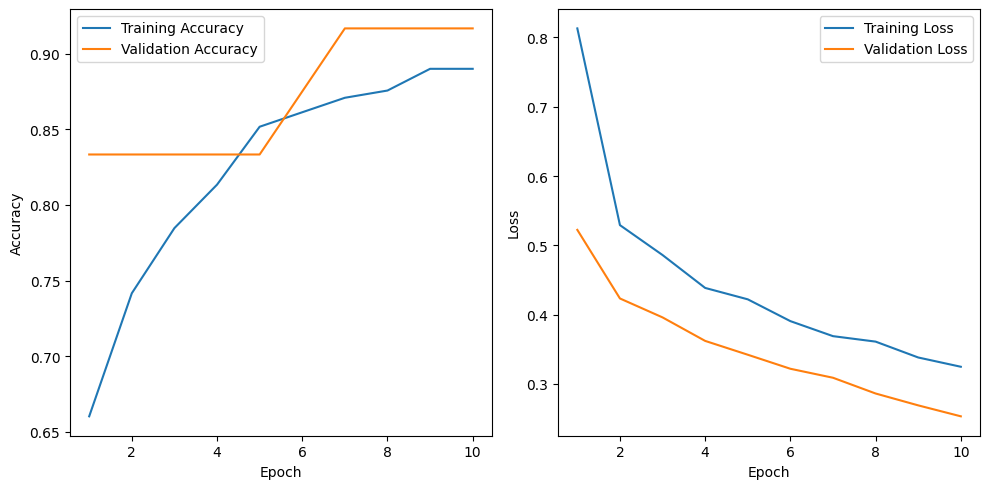

In [8]:
# Plot training and validation accuracy curves
import matplotlib.pyplot as plt

# Get the training and validation accuracy from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Get the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a plot to visualize the accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Create a plot to visualize the loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/bottle/ground_truth/contamination/000_mask.png'  # Replace with your test image path
test_image = load_img(test_image_path, target_size=(128, 128))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize pixel values

# Make predictions using the trained model
predictions = model.predict(test_image)

# Convert the predictions to labels (0: good, 1: anomaly)
predicted_label = np.argmax(predictions, axis=1)[0]
label_mapping = {0: 'good', 1: 'anomaly'}
predicted_class = label_mapping[predicted_label]

print("Predicted class:", predicted_class)


1/1 [==============================] - 1s 880ms/step
Predicted class: anomaly


In [16]:
# callback() -- api 배포 관련

# 4. Prediction

#5. FastAPI 배포

In [18]:
# from fastapi import FastAPI

# app = FastAPI()


# @app.get("/")
# async def root():
#     return {"message": "Hello World"}

In [11]:
%%capture
!pip install fastapi nest-asyncio pyngrok uvicorn

In [12]:
%%capture
!pip install fastapi
!pip install uvicorn
!pip install pyngrok

In [13]:
# Save model
model.save('history.h5')

In [14]:
from typing import Union
from fastapi import FastAPI, UploadFile, File
from tensorflow.keras.models import load_model
from starlette.requests import Request
from fastapi import FastAPI, HTTPException, UploadFile, File
from starlette.requests import Request
from starlette.responses import HTMLResponse
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import io


app = FastAPI()

# 모델 불러오기
model = load_model('history.h5')

@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.get("/items/{item_id}")
def read_item(item_id: int, q: Union[str, None] = None):
    return {"item_id": item_id, "q": q}